> Testing of binary sentiment classification on a IMDb movie review dataset.

---

# Setup

##### Set Root Dir as CWD

In [1]:
import os

# Navigate to project root (if not already there)
if os.path.split(os.getcwd())[1] != "cs374-project":
    %cd ../

D:\Documents\A_DIGIPEN\PersonalSVN\Fall22SVN\CS374\Project\cs374-project


##### Imports

In [2]:
import numpy as np
import pandas as pd

import spacy

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

# Local
from src.preprocesser import ReviewPreprocessor
from src.model import ReviewClassifier

In [3]:
from sklearn.model_selection import train_test_split

# Load

In [4]:
path = "data/steam/"

In [5]:
%%time
# Load dev set (10% of total data) as train
val = pd.read_csv(path + "dataset.csv")

CPU times: total: 13 s
Wall time: 13.2 s


In [8]:
# Get less samples
val, _ = train_test_split(val, train_size=50_000, stratify=val["review_score"])

In [18]:
# Ensure all strings
val["review_text"] = val.review_text.astype(str)

##### Save Target

In [19]:
# Save sentiment as boolean
y_val = val["review_score"] == 1
y_val

34659       True
5253414     True
4072570     True
6206239    False
3053446     True
           ...  
432606     False
5974508     True
5319591     True
4172651     True
441042      True
Name: review_score, Length: 50000, dtype: bool

# Preprocess

In [11]:
batch_size = 4000
n_processes = 4

maxlen = 200         # Number of words per review to consider
vocab_size = 20_000  # Size of vocabulary

prep_path = f"experiments/preprocessors/final.pickle"

##### Load from raw data

In [20]:
%%time
# Configure preprocessor based on comparison
prep = ReviewPreprocessor.load_from_pickle(prep_path)

# Preprocess text
X_val_norm = prep.normalize(val["review_text"], batch_size, n_processes)

# Convert to tensor of padded sequences
X_val = prep.to_tensor(X_val_norm)

CPU times: total: 32 s
Wall time: 1min 16s


##### View Before and After Preprocessing

In [22]:
print_idx = 8
print(val["review_text"].iloc[print_idx])
print("\n - - - - \n")
print(X_val_norm[print_idx], len(X_val_norm[print_idx]))
print("\n - - - - \n")
print(X_val[print_idx])

Super Mustache was a very dissapointinging game. I expected some supa kool kawaii mustache pazazz and i get dis ♥♥♥♥♥♥ puzzle platformer. U think i play dis, i would rather play super mario bros for the xbox. This game should not be called 'Super Mustache' it should be called 'Stupid Pooper Head'

 - - - - 

['ORG', 'ORG', 'was', 'a', 'very', 'dissapointinging', 'game', '.', 'i', 'expected', 'some', 'supa', 'kool', 'kawaii', 'mustache', 'pazazz', 'and', 'i', 'get', 'dis', 'PERSON', 'PERSON', 'PERSON', 'PERSON', 'PERSON', 'PERSON', 'puzzle', 'platformer', '.', 'u', 'think', 'i', 'play', 'ORG', ',', 'i', 'would', 'rather', 'play', 'super', 'mario', 'bros', 'for', 'the', 'xbox', '.', 'this', 'game', 'should', 'not', 'be', 'called', "'", 'ORG', 'ORG', 'ORG', 'it', 'should', 'be', 'called', "'", 'WORK_OF_ART', 'WORK_OF_ART', 'WORK_OF_ART', 'WORK_OF_ART'] 65

 - - - - 

tf.Tensor(
[   18    18     8     6    49   778     1     5   684    84 13374 11574
     3     5    62 13812    16    16   

# Model

##### Load Model

In [23]:
# From saved model (doesn't work with attn scores)
#model = keras.models.load_model("experiments/models/final_model")

# From checkpoint
embed_dim = 32  # Attention output size
num_heads = 2   # Number of attention heads
ff_dims = [32]  # Hidden layer sizes in feed forward network inside transformer
reg = 1.0e-2    # L2 Reg based on comparison
dropout = 0.3   # Dropout based on comparison
cp_path = "experiments/model_checkpoints/"
model = ReviewClassifier(maxlen, vocab_size, embed_dim, num_heads, ff_dims, reg, dropout)
model.load_weights(cp_path + f"final.ckpt")

In [24]:
model.predict(X_val[:5])

1/1 [==============================] - 2s 2s/step


array([[1.62519476e-09, 8.26779001e-09, 2.97904535e-05, 2.62024850e-02,
        9.73767757e-01],
       [3.06210406e-02, 2.26869993e-02, 4.92186993e-02, 2.00744271e-01,
        6.96729004e-01],
       [4.02504287e-04, 2.86975963e-04, 3.40298889e-03, 7.60246366e-02,
        9.19882894e-01],
       [6.01692080e-01, 1.00546844e-01, 2.93102078e-02, 4.60425690e-02,
        2.22408205e-01],
       [1.60670432e-04, 3.02710861e-04, 8.13897699e-03, 1.56797945e-01,
        8.34599674e-01]], dtype=float32)

# Evaluate

In [25]:
# Get probabilities per class
y_pred = model.predict(X_val)

1563/1563 [==============================] - 2s 1ms/step


In [26]:
# Calculate continuous star rating based on probabilities
star_reg = tf.reduce_sum(y_pred * np.array([0, 1, 2, 3, 4]), axis=1)
star_reg

<tf.Tensor: shape=(50000,), dtype=float64, numpy=
array([3.97370058, 3.51026599, 3.9146613 , ..., 3.95277902, 2.8843216 ,
       3.78094561])>

In [27]:
# Determine if sentiment is negative or postiive
y_pred_binary = star_reg >= 2

In [28]:
print("binary accuracy: " + str((y_pred_binary == y_val).numpy().sum() / len(y_val)))
print("(compare to ~0.5)")

binary accuracy: 0.81906
(compare to ~0.5)


##### Visualize Attention

In [22]:
# Get attention scores
_, attns = model(X_val[:100], return_att=True)

# Get attention for each sample
attns = tf.reduce_mean(attns, axis=2)[:, 0, :]
attns

<tf.Tensor: shape=(100, 200), dtype=float32, numpy=
array([[3.5445732e-03, 1.2494006e-02, 1.9155605e-02, ..., 7.6461699e-09,
        2.1221755e-10, 4.8084628e-02],
       [6.4915861e-03, 1.4879075e-01, 2.1933308e-01, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [1.5523669e-03, 1.7574768e-01, 6.2144117e-04, ..., 2.4621802e-10,
        2.4426347e-08, 2.8748524e-08],
       ...,
       [2.1435758e-01, 8.9798840e-03, 5.2412588e-08, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.0146836e-04, 6.1077247e-03, 8.8913605e-02, ..., 2.8045032e-11,
        4.1055009e-03, 3.1361555e-08],
       [2.3471093e-05, 1.7754437e-01, 1.2505965e-01, ..., 2.6696836e-05,
        4.2042211e-03, 3.6824733e-06]], dtype=float32)>

In [23]:
attns[0][:34]

<tf.Tensor: shape=(34,), dtype=float32, numpy=
array([3.5445732e-03, 1.2494006e-02, 1.9155605e-02, 1.0774131e-01,
       1.8801376e-01, 7.6504983e-03, 1.0714605e-01, 4.0157047e-06,
       1.4494486e-03, 1.4054523e-04, 2.0329878e-07, 4.3246388e-02,
       6.2153226e-04, 3.8715727e-03, 4.4076633e-06, 3.7952331e-03,
       7.6869931e-03, 1.7510286e-02, 6.7335197e-05, 1.5638797e-02,
       1.1256127e-06, 2.6232949e-03, 2.2619017e-03, 3.5805228e-05,
       1.0287581e-05, 3.5656402e-07, 9.8734386e-03, 2.9696450e-03,
       1.0313178e-02, 7.9576488e-08, 1.0125336e-06, 1.6604311e-08,
       2.2623732e-09, 9.3440833e-10], dtype=float32)>

<Original Text>
Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. <br /><br />The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best performance he at least seems to be making a bit of an effort. One for Keitel obsessives only.

<Preprocessed>
['encouraged', 'by', 'the', 'positive', 'comments', 'about', 'this', 'film', 'on', 'here', 'i', 'was', 'looking', 'forward', 'to', 'watching', 'this', 'film', 'bad', 'mistake', 'i', "'", 've', 'seen', '95', 'e1', 'films', 'and', 'this', 'is', 'truly', 'cardinal', 'of', 'the', 'worst', 

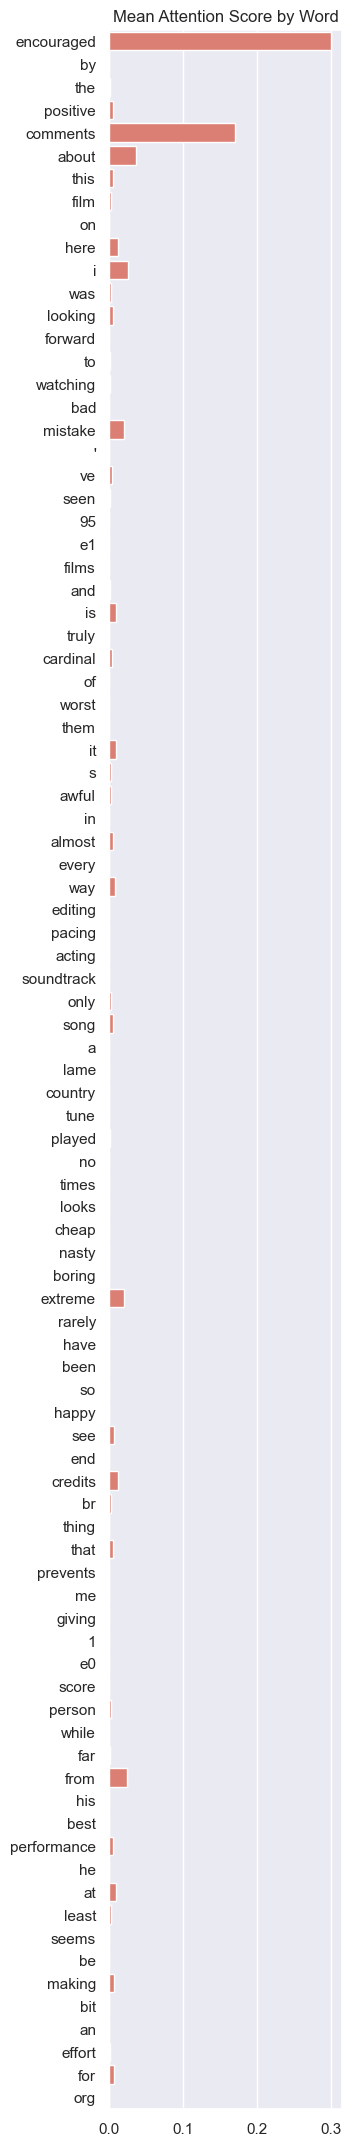

In [25]:
sample_idx = 8

# Get word sequences without oov words
in_seq = X_val_norm[sample_idx][:maxlen]
in_seq = [tok for tok in prep.tokenizer.sequences_to_texts(prep.tokenizer.texts_to_sequences(in_seq)) if tok]
seq_len = len(in_seq)

# Get attention values
attn_vals = attns[sample_idx][:seq_len].numpy()

print("<Original Text>")
print(val["review"].iloc[sample_idx])

print("\n<Preprocessed>")
print(in_seq)

plt.figure(figsize=(3, 0.2 * seq_len), dpi=100)
sns.barplot(y=in_seq, x=attn_vals, ci=None, color="#EC7063")

plt.title("Mean Attention Score by Word")

#plt.gca().set_yticklabels(in_seq)

plt.show()